# Градиентный спуск и его модификации
- Выбрать тестовые функции оптимизации (2 шт.)
- Запрограммировать собственную реализацию классического градиентного спуска
- Запрограммировать пайплайн тестирования алгоритма оптимизации
    - Визуализации функции и точки оптимума
    - Вычисление погрешности найденного решения в сравнение с аналитическим для нескольких запусков
    - Визуализации точки найденного решения (можно добавить анимацию на плюс балл)
- Запрограммировать метод вычисления градиента
    - Передача функции градиента от пользователя
    - Символьное вычисление градиента (например, с помощью sympy) (на доп. балл)
    - Численная аппроксимация градиента (на доп. балл)
- Запрограммировать одну моментную модификацию и протестировать ее
- Запрограммировать одну адаптивную модификацию и протестировать ее
- Запрограммировать метод эфолюции темпа обучения и/или метод выбора начального приближения и протестировать их

In [1]:
# импорт модулей
from matplotlib import pyplot as plt
import numpy as np
import sympy as sp

np.set_printoptions(suppress=True, formatter={'float_kind': '{:0.02f}'.format})

## Функции оптимизации

В качестве тестовых функций оптимизации были выбраны **функция сферы** и **функция Матьяса** (Matyas).

Все функции задаются с помощью единого класса Function, умеющего обрабатывать функцию как строку.

Абстрактный класс и классы-наследники содержат поля:
- название функции `title`
- аналитический минимум `minimum` (необходим для визуализации и расчёта погрешности)
- строка-символьное представление обрабатываемой функции `expression`

А также методы:
- значение функции `function`
- значения градиента по x и по y `gradient` (**символьное вычисление!**)

In [2]:
class Function:
    def __init__(self, title: str, minimum: np.array, expression: str):
        super().__init__()
        self.title = title
        self.minimum = minimum
        self.expression = expression

        x, y = sp.symbols('x y')
        self.diff_expression_x = str(sp.diff(self.expression, x))
        self.diff_expression_y = str(sp.diff(self.expression, y))

    def function(self, args: np.array):
        x, y = args
        return eval(self.expression)

    def gradient(self, args: np.array):
        x, y = args
        df_dx = eval(self.diff_expression_x)
        df_dy = eval(self.diff_expression_y)
        return np.array([df_dx, df_dy])

Расчёт классического градиентного спуска производится с помощью функции `classic_gd`. Результаты расчётов возвращаются в numpy-массиве numpy-массивов, каждый из которых содержит:
- координату градиента в некоторой точке по X
- координату градиента в некоторой точке по Y
- значение функции в указанных координатах

для каждой пятой точки.

In [3]:
def classic_gd(function: Function, initial_point: np.array, learning_rate: float, num_iterations: int = 1000,
               convergence_radius: float = 10 ** -7) -> np.array:
    """Расчёт градиентного спуска

            Args:
                function (Function): анализируемая функция
                initial_point (np.array): начальная точка градиента
                num_iterations (int): количество итераций
                learning_rate (float): размер шага для каждой итерации
                convergence_radius (float): радиус сходимости
    """

    arguments = initial_point.copy()
    history = [np.array([arguments[0], arguments[1], function.function(arguments)])]

    for current_iteration in range(num_iterations):
        arguments = arguments - learning_rate * function.gradient(arguments)

        # Сохраняем каждую пятую итерацию
        if current_iteration % 5 == 0:
            history.append(np.array([arguments[0], arguments[1], function.function(arguments)]))
        if history[-2][-1] - history[-1][-1] < convergence_radius:
            break

    return np.array(history)

Функции с аналогичными параметрами отвечают за расчёт моментной и адаптивной модификаций

In [4]:
def momentum_gd(function: Function, initial_point: np.array, learning_rate: float, num_iterations: int = 1000,
                convergence_radius: float = 10 ** -7, beta: float = 0.5) -> np.array:
    """Расчёт градиентного спуска с моментной модификацией

            Args:
                :param function: анализируемая функция
                :param initial_point: начальная точка градиента
                :param learning_rate: размер шага для каждой итерации
                :param num_iterations: количество итераций
                :param convergence_radius: радиус сходимости
                :param beta: коэффициент момента
    """

    arguments = initial_point.copy()
    arguments_old = initial_point.copy()
    history = [np.array([arguments[0], arguments[1], function.function(arguments)])]

    for current_iteration in range(num_iterations):
        arguments_new = (arguments - learning_rate * function.gradient(arguments) + beta *
                         (arguments - arguments_old))
        arguments_old = arguments
        arguments = arguments_new

        # Сохраняем каждую пятую итерацию
        if current_iteration % 5 == 0:
            history.append(np.array([arguments[0], arguments[1], function.function(arguments)]))
        if history[-2][-1] - history[-1][-1] < convergence_radius:
            break

    return np.array(history)

In [5]:
def adam_gd(function: Function, initial_point: np.array, learning_rate: float, num_iterations=1000,
            convergence_radius=10 ** -7, beta1: float = 0.9, beta2: float = 0.9, e: float = 10e-8):
    """

            Args:
                :param function: анализируемая функция
                :param initial_point: начальная точка градиента
                :param learning_rate: размер шага для каждой итерации
                :param num_iterations: количество итераций
                :param convergence_radius: радиус сходимости
                :param beta1: параметр сглаживания
                :param beta2: параметр сглаживания
                :param e: бесконечно малое число
    """

    # начальный набор параметров
    arguments = initial_point.copy()
    history = [np.array([arguments[0], arguments[1], function.function(arguments)])]

    # инициализация моментов
    m = np.array([0, 0])
    v = np.array([0, 0])

    for current_iteration in range(num_iterations):
        # расчёт моментов
        m = beta1 * m + (1 - beta1) * function.gradient(arguments)
        v = beta2 * v + (1 - beta2) * function.gradient(arguments) ** 2

        arguments = arguments - learning_rate * m / (np.sqrt(v) + e)

        # Сохраняем каждую пятую итерацию
        if current_iteration % 5 == 0:
            history.append(np.array([arguments[0], arguments[1], function.function(arguments)]))
        if history[-2][-1] - history[-1][-1] < convergence_radius:
            break

    return np.array(history)

Вся визуализация производится с помощью функции `plot3d`, а вспомогательная функция `two_point_distance` отвечает за расчёт растояния между двумя точками (необходима для расчёта погрешности):

In [6]:
def plot3d(function: Function, traces: list, bounds) -> None:
    """Визуализация градиентного спуска

        Args:
            :param function: объект класса функции оптимизации
            :param launch_story: история запусков, необходима для расчёта погрешности
            :param traces: история изменения градиента
    """

    fig = plt.figure(figsize=(10, 10))  # Размер холста
    ax = fig.add_subplot(111, projection='3d')

    # Блок, отвечающий за график функции с заданными ограничениями
    x = np.linspace(bounds[0, 0], bounds[0, 1], 100)  # Заданные ограничения
    y = np.linspace(bounds[1, 0], bounds[1, 1], 100)
    X, Y = np.meshgrid(x, y)
    Z = function.function(np.array([X, Y]))  # Отрисовка функции

    print('===============')
    print(function.title)
    # Блок, отвечающий за график градиента, а также начальную точку и точку минимума
    ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.5)
    for index, trace in enumerate(traces):
        print(f"Начальная точка, запуск {index}:\t{trace[0]}")
        print(f"Найденный минимум, запуск {index}:\t{trace[-1]}")
        print(f"Кол-во итераций, запуск {index}:\t{len(trace) * 5}")
        ax.plot(trace[:, 0], trace[:, 1], trace[:, 2], '-o', c='black', label=f'Градиентный спуск {index + 1}',
                alpha=0.7)
        #  Отрисовка истории изменения градиента
        ax.scatter3D(trace[0, 0], trace[0, 1], trace[0, 2], s=50, c="white", lw=2, ec='black', marker='D',
                     label=f'Начальная точка {index + 1}')
        ax.scatter3D(trace[-1, 0], trace[-1, 1], trace[-1, 2], s=80, c="white", lw=2, ec='black', marker='X',
                     label=f'Найденный минимум {index + 1}')

    min_z = function.function(function.minimum)  # Отрисовка точки минимума
    ax.scatter(function.minimum[0], function.minimum[1], min_z, color='red', marker='o', s=200, label='Минимум')

    errors = []
    for trace in traces:
        errors.append(two_point_distance(trace[-1][0:2], function.minimum))

    np.set_printoptions(formatter={'float_kind': "{:.2f}".format})
    print(f"Глобальный минимум:\t{function.minimum}")
    print(f"Погрешность (3 запуска):\t{(sum(errors) / len(errors)):0.4f}")
    fig.text(0.9, 0.06, s=f"Погрешность ({len(traces)} запуска): {(sum(errors) / len(errors)):0.4f}",
             horizontalalignment="right", fontsize=12)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(function.title)  # Вывод заголовка

    ax.legend(loc="upper left")
    plt.show()


def two_point_distance(a: np.array, b: np.array):
    return pow((abs(a[0]) - abs(b[0])) ** 2 + (abs(a[1]) - abs(b[1])) ** 2, 0.5)

Для непосредственной визуализации требуется объект класса визуализируемой функции и начальная точка градиента. Для наглядности расчёт градиента функции с помощью всех реализаций визуализируется на одном графике, но с использованием разных начальных точек:

Sphere Function
Начальная точка, запуск 0:	[4.00 4.00 32.00]
Найденный минимум, запуск 0:	[0.00 0.00 0.00]
Кол-во итераций, запуск 0:	170
Начальная точка, запуск 1:	[-4.00 4.00 32.00]
Найденный минимум, запуск 1:	[-0.00 0.00 0.00]
Кол-во итераций, запуск 1:	80
Начальная точка, запуск 2:	[-4.00 -4.00 32.00]
Найденный минимум, запуск 2:	[0.06 0.06 0.01]
Кол-во итераций, запуск 2:	155
Глобальный минимум:	[0.00 0.00]
Погрешность (3 запуска):	0.0278


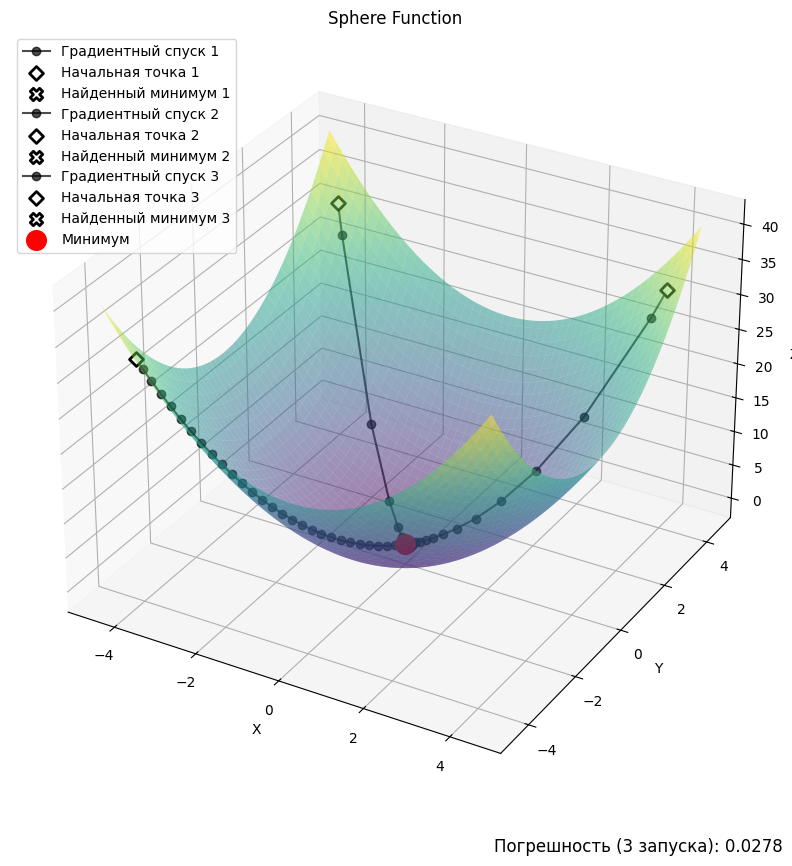

In [7]:
bounds = np.array([[-4.5, 4.5], [-4.5, 4.5]])

sphere = Function(title='Sphere Function', minimum=np.array([0., 0.]), expression='x ** 2 + y ** 2')
traces = [classic_gd(sphere, initial_point=np.array([4, 4]), learning_rate=0.03),
          momentum_gd(sphere, initial_point=np.array([-4, 4]), learning_rate=0.03),
          adam_gd(sphere, initial_point=np.array([-4, -4]), learning_rate=0.03)]

plot3d(sphere, traces=traces, bounds=bounds)

Matyas Function
Начальная точка, запуск 0:	[4.00 4.00 0.64]
Найденный минимум, запуск 0:	[0.01 0.01 0.00]
Кол-во итераций, запуск 0:	1570
Начальная точка, запуск 1:	[-4.00 4.00 16.00]
Найденный минимум, запуск 1:	[0.00 -0.00 0.00]
Кол-во итераций, запуск 1:	45
Начальная точка, запуск 2:	[-4.00 -4.00 0.64]
Найденный минимум, запуск 2:	[0.21 0.21 0.00]
Кол-во итераций, запуск 2:	60
Глобальный минимум:	[0.00 0.00]
Погрешность (3 запуска):	0.1028


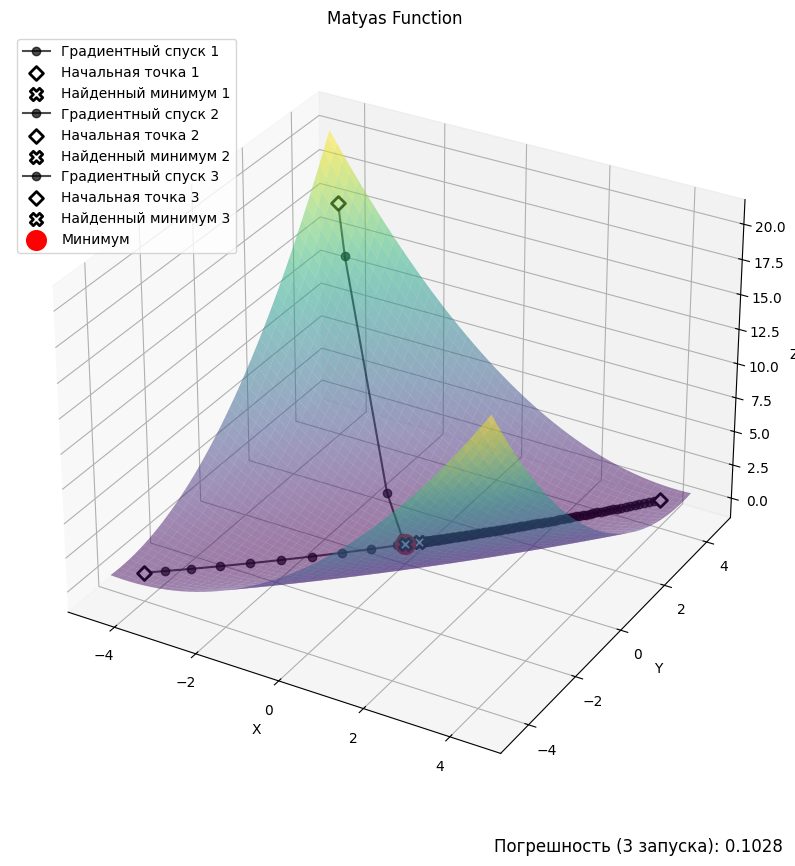

In [8]:
matyas = Function(title='Matyas Function', minimum=np.array([0., 0.]),
                  expression='0.26 * (x ** 2 + y ** 2) - 0.48 * x * y')
traces = [classic_gd(matyas, initial_point=np.array([4, 4]), learning_rate=0.1, num_iterations=2000),
          momentum_gd(matyas, initial_point=np.array([-4, 4]), learning_rate=0.1),
          adam_gd(matyas, initial_point=np.array([-4, -4]), learning_rate=0.1)]

plot3d(matyas, traces=traces, bounds=bounds)

Класс Function позволяет принять вообще любую функцию, если ввести с клавиатуры её название, аналитический минимум и символьную запись (что демонстрирует закомментированный код):

Booth Function
Начальная точка, запуск 0:	[7.50 7.50 546.50]
Найденный минимум, запуск 0:	[1.00 3.00 0.00]
Кол-во итераций, запуск 0:	145
Начальная точка, запуск 1:	[-7.50 7.50 156.50]
Найденный минимум, запуск 1:	[1.00 3.00 0.00]
Кол-во итераций, запуск 1:	85
Начальная точка, запуск 2:	[-7.50 -7.50 1626.50]
Найденный минимум, запуск 2:	[0.91 3.07 0.01]
Кол-во итераций, запуск 2:	400
Глобальный минимум:	[1 3]
Погрешность (3 запуска):	0.0372


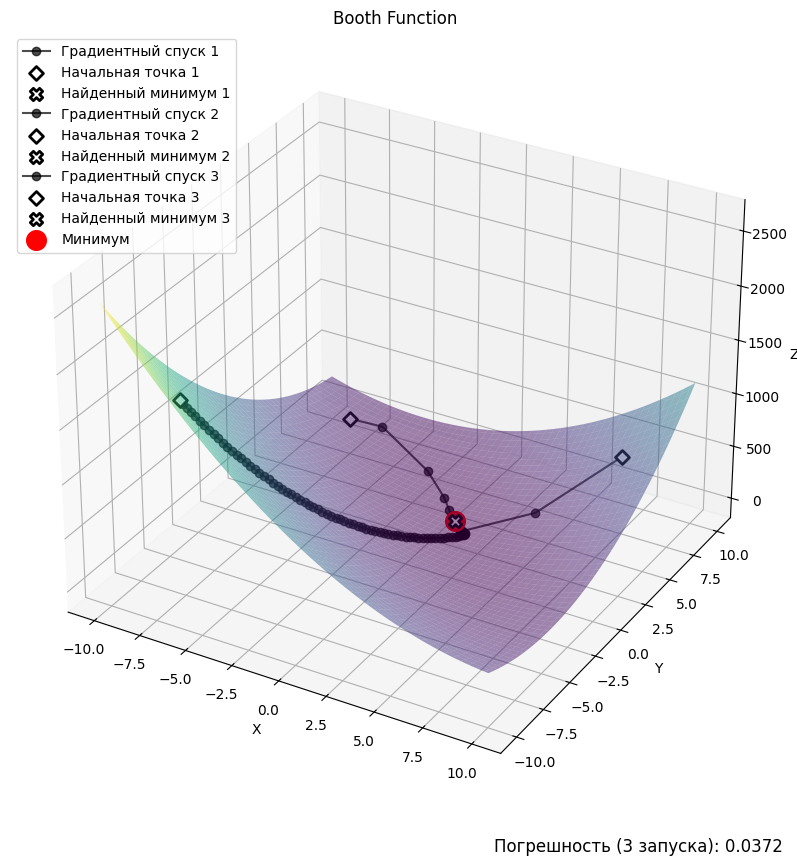

In [9]:
bounds = np.array([[-10, 10], [-10, 10]])

title = 'Booth Function'
expression = '(x + 2 * y - 7) ** 2 + (2 * x + y - 5) ** 2'
minimum = np.array([int(i) for i in '1, 3'.split(', ')])
# title = input('Input name of your function, i.e. "Booth Function": ')
# expression = input('Input your function f(x, y), i.e. "(x + 2 * y - 7) ** 2 + (2 * x + y - 5) ** 2": ')
# minimum = np.array([int(i) for i in input('Input minimum, i.e. "1, 3": ').split(', ')])
user = Function(title=title, minimum=minimum, expression=expression)

traces = [classic_gd(user, initial_point=np.array([7.5, 7.5]), learning_rate=0.03),
          momentum_gd(user, initial_point=np.array([-7.5, 7.5]), learning_rate=0.03),
          adam_gd(user, initial_point=np.array([-7.5, -7.5]), learning_rate=0.03)]

plot3d(user, traces=traces, bounds=bounds)